# 3D reconstruction

## Ray-tracing/camera-model

In [13]:
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [14]:
H = 400
W = 400
f = 1200

In [15]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

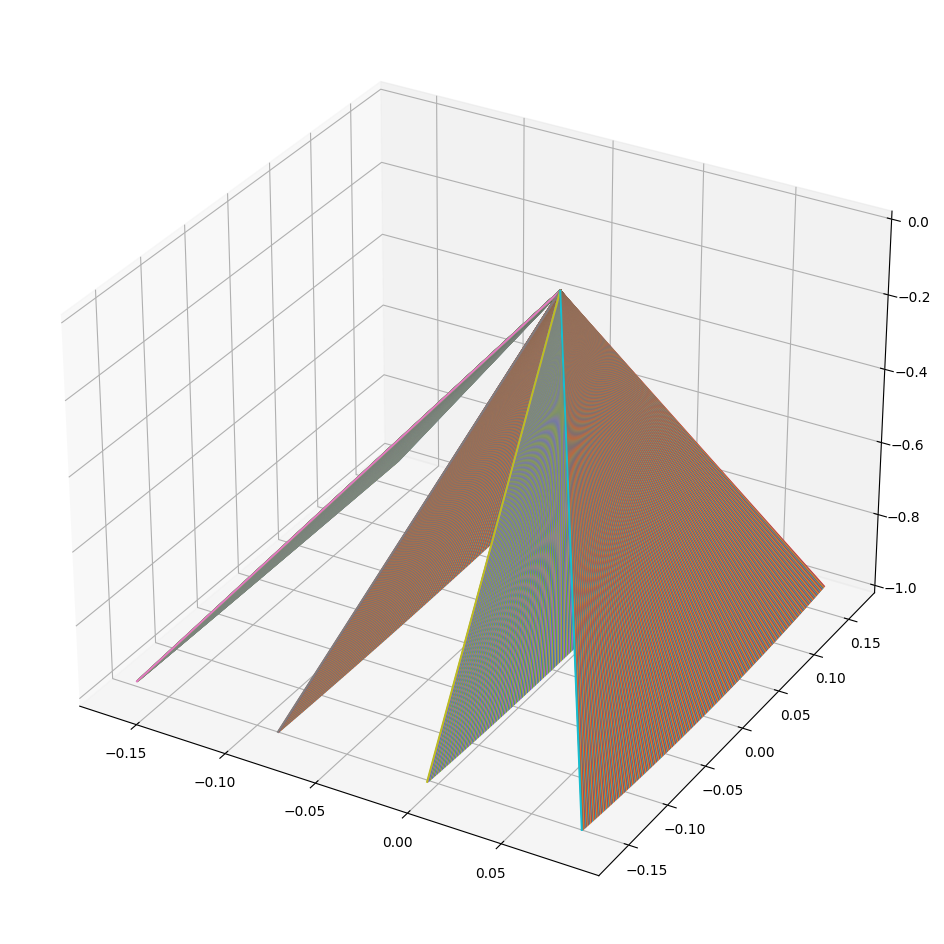

In [16]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    plt.show()


plot_rays(rays_o, rays_d, 1)


## 3D rendering

In [17]:
class Sphere():
    
    def __init__(self, position, radius, color):
        self.p = position
        self.r = radius
        self.c = color
        
    def intersect(self, o, d):
        
        # Solve equation at^2 + bt + c = 0
        # (ox + t * dx  - xc)^2 + (oy + t * dy-yc)^2 + (oz + t * dz-zc)^2 = r^2 
        a = d[:, 0]**2 + d[:, 1]**2 + d[:, 2]**2
        b = 2 * ((d[:, 0] * (o[:, 0] - self.p[0])) + (d[:, 1] * (o[:, 1] - self.p[1])) + (d[:, 2] * (o[:, 2] - self.p[2])))
        c = (o[:, 0] - self.p[0])**2 + (o[:, 1] - self.p[1])**2 + (o[:, 2] - self.p[2])**2 - self.r**2
        
        pho = b**2 - 4 * a * c
        cond = pho >= 0
        
        num_rays = o.shape[0]
        colors = np.zeros((num_rays, 3))
        colors[cond] = self.c
        
        return colors

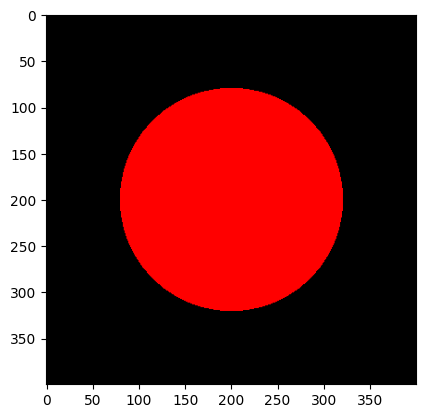

In [18]:
s = Sphere(np.array([0., 0., -1.]), .1, np.array([1., 0., 0.]))
img = s.intersect(rays_o, rays_d)
img = img.reshape(H, W, 3)

plt.figure()
plt.imshow(img)
plt.show()

## volmetric rendering

In [19]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 10
        
        return colors, density

In [20]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1) 
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]

    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [21]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 0., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

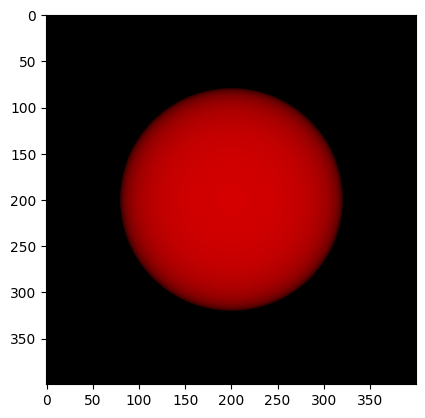

In [22]:
img = px_colors.reshape(H, W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)

## Differentiable rendering/Optimization

In [23]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 0., 0.]))
b = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

c_to_optimize = torch.tensor([0., 0., 0.], requires_grad=True)
optimizer = torch.optim.SGD({c_to_optimize}, lr=1e-1)

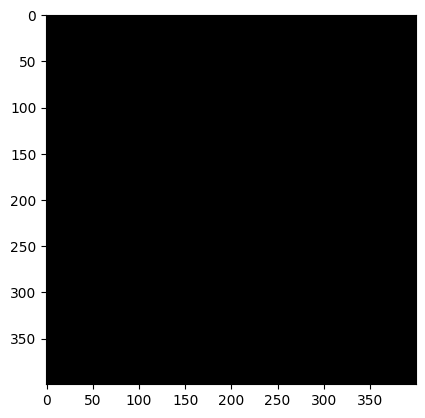

0.045533686876297
tensor([0.0091, 0.0000, 0.0000], requires_grad=True)


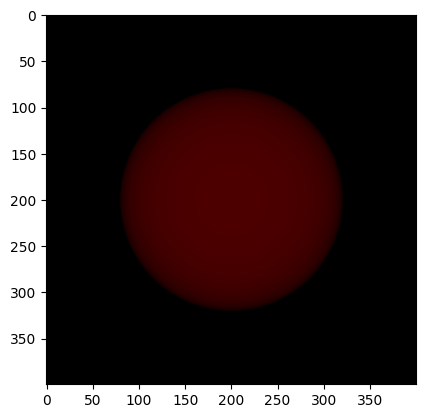

0.018239812925457954
tensor([0.3729, 0.0000, 0.0000], requires_grad=True)


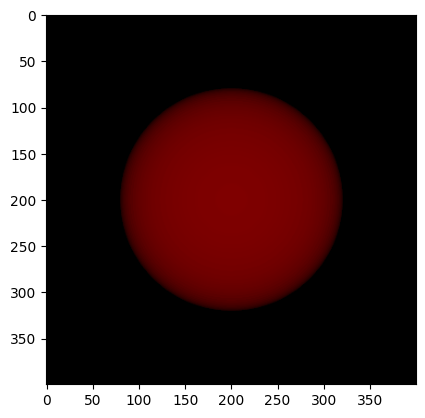

0.007306473795324564
tensor([0.6031, 0.0000, 0.0000], requires_grad=True)


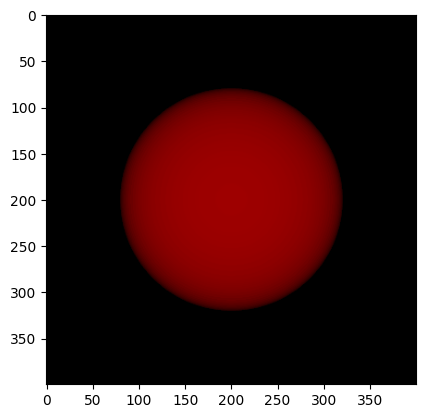

0.002926815301179886
tensor([0.7488, 0.0000, 0.0000], requires_grad=True)


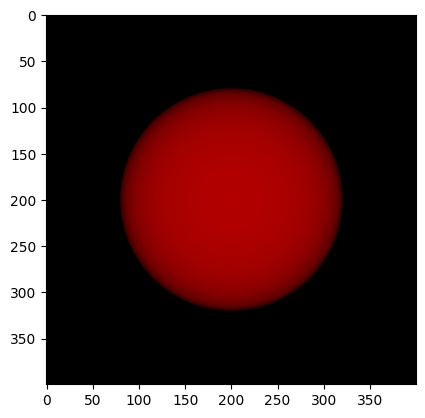

0.0011724188225343823
tensor([0.8410, 0.0000, 0.0000], requires_grad=True)


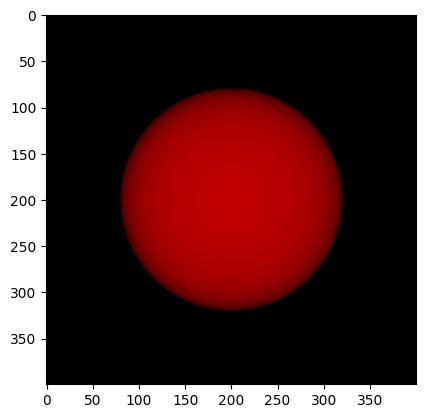

0.0004696477553807199
tensor([0.8994, 0.0000, 0.0000], requires_grad=True)


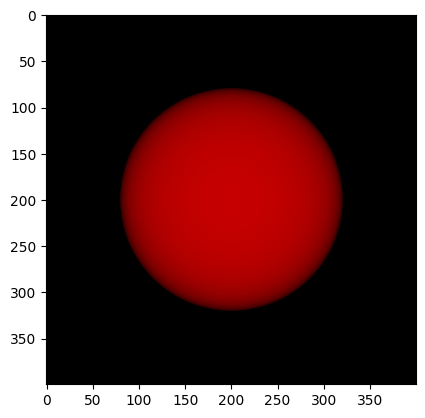

0.00018813091446645558
tensor([0.9363, 0.0000, 0.0000], requires_grad=True)


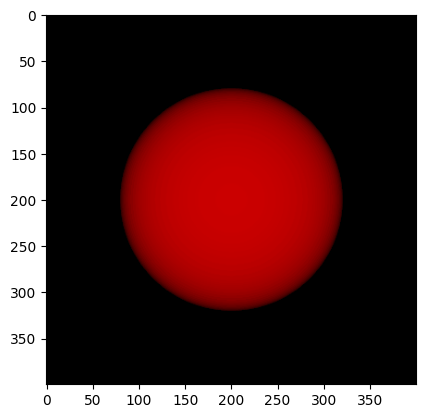

7.536086195614189e-05
tensor([0.9597, 0.0000, 0.0000], requires_grad=True)


In [24]:
for epoch in range(400):
        
    model = Sphere(torch.tensor([0, 0, -1]), 0.1, c_to_optimize)
    Ax = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

    loss = ((Ax - b)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        img = Ax.reshape(H, W, 3).cpu().data.numpy()
        plt.imshow(img)
        plt.show()
        
        print(loss.item())
        print(c_to_optimize)
        

## Rotation matrix to camera

In [28]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))


c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

In [29]:
c2w = c2w2

rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)

dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

rays_o += c2w[:3, 3]

In [32]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 10
        
        color_condition = x[:, 0] < 0
        tmp = colors[color_condition, 0].clone()
        colors[color_condition, 0] = colors[color_condition, 1].clone()
        colors[color_condition, 1] = tmp
        
        return colors, density

In [33]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1) 
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    
    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]

    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    
    return c

In [34]:
model = Sphere(torch.tensor([0, 0, 0]), 1, torch.tensor([1., 0., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 8, 12)

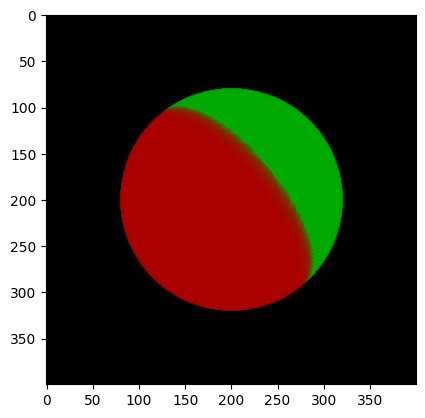

In [35]:
img = px_colors.reshape(H, W, 3).cpu().numpy()
plt.figure(dpi=100)
plt.imshow(img)